Geçen haftalarda önümüzdeki bir problem için farklı modeller kurmuştuk. Bu modellerin hiper-parametrelerini seçip başarı oranlarını kıyaslayıp uygun modelle yolumuza devam etmiştik.

Eğer en iyi modeli ve en iyi parametreleri seçmek bize yetmiyorsa modelimizi daha da geliştirmek istiyorsak bir üst aşamaya ensemble modellere geçme zamanımız gelmiş demektir.

Ensemble model birçok modelin uyum içinde birbirlerinin eksiklerini tamamlayarak daha başarılı bir model oluşturmasıdır.

Bununla ilgili güzel bir anekdot var: İstatistikçi Francis Galton 1907 yılında Plymouth festivalinde bir boğanın ağırlığının tahmin edildiği bir yarışma denk gelir. 800 kişinin hiçbiri 1198 pound ağırlığındaki boğayı doğru tahmin edemez fakat tahminlerin ortalaması 1197'dir. (The Wisdom of Crowds!)

ASSIGNMENT 5

Q1. Mahkeme salonunda 5 jüri üyesi var. Herbiri bağımsız olarak sanığın 
suçlu olup olmadığını yüzde 70 olasılıkla doğru tahmin ediyor. Eğer son karar 
çoğunluk oyuyla belirlenirse doğru karar verme olasılığı nedir?

    a. 70.00%
    b. 83.20%
    c. 83.70%
    d. 87.50%

Teorem ile ilgili başlığa buradan ulaşabilirsiniz. 
Condorcet's jury theorem https://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem

In [ ]:
Doğru kararın çıkması için çoğunluğun sağlanması gerekiyor. O sebeple 
(5 3) (5 4) (5 5) kombinasyonlarını inceliyoruz. 

(5 3) * ((0.7)**3) * (((0.3)**2)) + (5 4) * ((0.7)**4) * (((0.3)**1)) + (5 5) * ((0.7)**5), 3))

In [1]:
print(round(10 * ((0.7)**3) * (((0.3)**2)) + 5 * ((0.7)**4) * (((0.3)**1)) + 1 * ((0.7)**5), 3))

0.837


In [10]:
#ortam hazırlıklarını yapıyoruz
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib import rcParams
rcParams['figure.figsize'] = 11,8

data = pd.read_csv('https://raw.githubusercontent.com/HakkiKaanSimsek/mlcourse_open/master/data/credit_scoring_sample.csv', sep = ';')

#NaN değerleri o kategorinin medyan değerleriyle değiştirecek bir fonksiyon yazıyoruz.
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table
  
#Veri tiplerine bi bakalım.
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

In [11]:
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

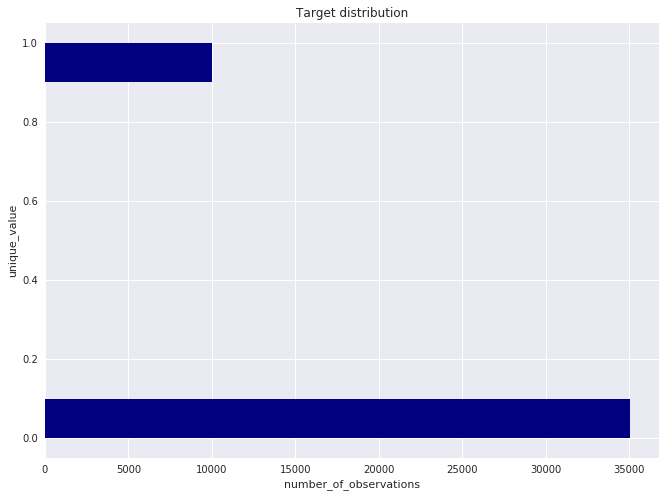

In [12]:
#Şimdi de hedef değişkenimiz SeriousDlqin2yrs dağılımına bakalım. 
#Hedef değişkenimiz müşteri 90 gün içerisinde kredisini 
#ödemişse 0 ödememişse 1 değerini alıyor.

ax = data['SeriousDlqin2yrs'].hist(orientation = 'horizontal', color = 'navy')
ax.set_xlabel('number_of_observations')
ax.set_ylabel('unique_value')
ax.set_title('Target distribution')

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [17]:
#LOGISTIC REGRESYON

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(random_state = 5, class_weight = 'balanced')

Dengesiz bir veri setimiz olduğu için class_weight='balanced' kullanarak
bir regresyon modeli oluşturuyoruz.

Q3. C parametreleri için Grid Search yapıldığında optimal C değeri nedir?

    a. 0.0001
    b. 0.001
    c. 0.01
    d. 0.1
    e. 1
    f. 10

In [18]:
#NaN değerleri dolduran fonksiyonumuzu kullanıyoruz şimdi de.
table = fill_nan(data)

# Tahmin etmek istediğimiz değişkenleri ve diğerlerini ayırıyoruz.
X = table.drop('SeriousDlqin2yrs', axis = 1)
y = table['SeriousDlqin2yrs']

#Bootstrapping

#Q2. Ödemesini geciktiren kullancıların yaş ortalamarı için 
#yüzde 90 güven aralığında tahmin yapmamız isteniyor.

def get_bootstrap_samples(data_set, n_samples):
    indices = np.random.randint(0, len(data_set), (n_samples, len(data_set)))
    samples = data_set[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

delayed_people = data[data['SeriousDlqin2yrs'] == 1]['age'].values

# Sonuçların tekrar tekrar üretilmesi için bir seed değeri belirliyoruz.
np.random.seed(0)

#Bootstrapping ile yeni örneklemler üretiyoruz ve her biri için ortalamalarını hesaplıyoruz.
delayed_mean_age = [np.mean(sample) 
                       for sample in get_bootstrap_samples(delayed_people, 1000)]


print("Gecikmeli ödeme yapan kişilerin: yaş aralığı", 
stat_intervals(delayed_mean_age, 0.10))

Gecikmeli ödeme yapan kişilerin: yaş aralığı [45.71379414 46.12700479]


In [19]:
#Logistic regresyon modelimiz için en iyi düzenlileştirme (regularization) parametresini bulmaya çalışacağız.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

#C'nin optimal değerini bulmak için 5-fold validation (5 katlamalı çarpraz doğrulama) 
#uyguluyoruz ve farklı C değerleri için ROC AUC sonuçlarını kıyaslıyoruz.

#Modelin kalitesini gösteren en iyi metriklerden biri Curve Altında Kalan Alan (AUC)'dır. 
#ROC AUC 1'e yaklaştıkça sınıflandırma modelinin kalitesi artıyor demektir.

clf = GridSearchCV(lr,parameters,scoring='roc_auc',refit=True,cv=5)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.7955, with best C: {'C': 0.001}


Q4.En iyi modeli sabit olarak kabul edebilir miyiz? 
(cross-validation skorlarının standart sapmasının 5∗10−3 değerinden az olması.)
- !En iyi modelin ROC AUC değerini kaydedin, bundan sonraki sorular için önemli.

In [20]:
clf.grid_scores_

/home/dockeruser/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79018, std: 0.00595, params: {'C': 0.0001},
 mean: 0.79548, std: 0.00534, params: {'C': 0.001},
 mean: 0.79109, std: 0.00475, params: {'C': 0.01},
 mean: 0.78870, std: 0.00453, params: {'C': 0.1},
 mean: 0.78821, std: 0.00446, params: {'C': 1},
 mean: 0.78799, std: 0.00434, params: {'C': 10}]

In [21]:
print('Cross-validation skorlarının standart sapması {0}'. format(round(np.std([0.79018, 0.79548, 
                                                           0.79109, 0.78870, 0.78821, 0.78799]), 6)))

Cross-validation skorlarının standart sapması 0.002573


Q5. Bir özniteliğin önemi ilgili özniteliğin katsayısının mutlak değeri olarak tanımlanır. 
Karşılaştırma yapabilmemiz için bütün öznitelik değerlerini normalize etmeliyiz. 
Regresyon modeli için en önemli öznitelik nedir?

    a. age
    b. NumberOfTime30-59DaysPastDueNotWorse
    c. DebtRatio
    d. NumberOfTimes90DaysLate
    e. NumberOfTime60-89DaysPastDueNotWorse
    f. MonthlyIncome
    g. NumberOfDependents

In [22]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

Şimdi normalize edilmiş yeni değerlerle tekrar bir model kurmalıyız. 
Bu model için öcelikle en ideal regularization (C) parametresini bulalım.

C'nin optimal değerini bulmak için GridSearchCV uyguluyoruz 
ve farklı C değerleri için ROC AUC sonuçlarını kıyaslıyoruz.

In [23]:
clf = GridSearchCV(lr,parameters,scoring='roc_auc',refit=True,cv=5)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.7878, with best C: {'C': 10}


In [24]:
#ROC_AUC değerimizi maksimum yapan C parametresi 10, modeli buna göre tekrar kuralım.
lr = LogisticRegression(C=10, random_state=5, class_weight = 'balanced').fit(X, y)

In [25]:
#Özniteliklerin katsayılarına bakalım şimdi de.
print(lr.coef_)
print('Regresyon modeli için en önemli öznitelik NumberOfTime30-59DaysPastDueNotWorse')

[[-0.4364889   3.27729131 -0.04235577  3.06538284  0.07658622 -0.20397173
   0.08526854]]
Regresyon modeli için en önemli öznitelik NumberOfTime30-59DaysPastDueNotWorse


Q6. Logistik Regresyon modelinde DebtRatio özniteliğinin etkisi nedir? Softmax fonksiyonuyla hesaplayın.
   - a. 0.38
   - b.-0.02
   - c. 0.11
   - d. 0.24

In [26]:
#Özniteliklerimizin katsayılarını bulmuştuk, şimdi bu değerlere softmax fonksiyonunu uyguluyoruz.
#Softmax fonksiyonu negatif değer kabul etmiyor, aman dikkat.

import math
z = [0.4364889 ,  3.27729131, 0.04235577,  3.06538284,  0.07658622,
        0.20397173,  0.08526854]
z_exp = [math.exp(i) for i in z]
sum_z_exp = sum(z_exp)
softmax = [roundDate:   Fri Mar 30 10:18:51 2018 -0700

    dosyalar eklendi.

commit ac3b1ad99a6e32ec4cd4d706df1443563e6ce581
Author: HakkiKaanSimsek <hkaansimsek@gmail.com>
Date:   Fri Mar 30 10:14:45 2018 -0700

Date:   Fri Mar 30 10:18:51 2018 -0700

    dosyalar eklendi.

commit ac3b1ad99a6e32ec4cd4d706df1443563e6ce581
Author: HakkiKaanSimsek <hkaansimsek@gmail.com>
Date:   Fri Mar 30 10:14:45 2018 -0700

d(i / sum_z_exp, 4) for i in z_exp]
print(softmax)

[0.0287, 0.4914, 0.0193, 0.3976, 0.02, 0.0227, 0.0202]


DebtRatio özniteliğinin etkisi 0.0193 olarak gözüküyor, katsayısı negatif olduğu için yuvarlanmış cevap -0.02

Q7. Lojistik regresyonu scale edilmemiş orjinal özniteliklerle tekrar eğitelim. 
Sonrasında diğer öznitelikleri sabit tutup her müşterinin yaşına 20 ekleyelim. 
Orjinal ve 20 yıl sonraki yaşların olduğu iki modelle tahminler yapıp oranlayalım. (2. model/1. model)

    a. -0.01
    b. 0.70
    c. 8.32
    d. 0.66

In [28]:
X = table.drop('SeriousDlqin2yrs', axis = 1)
y = table['SeriousDlqin2yrs']

#ilk başta bulduğumuz C parametresiyle modelimizi kurup katsayıları hesaplıyoruz.
lr = LogisticRegression(C=0.001, random_state=5, class_weight = 'balanced')
lr.fit(X,y)
lr.coef_

array([[-1.81852819e-02,  4.82349233e-01, -1.07983115e-05,
         4.30314156e-01,  6.59578704e-02, -1.14476586e-05,
         1.15356249e-01]])

In [29]:
#yaş özniteliğinin katsayısı -1.81852819e-02, tahmin edilen olasılık değişimi 
#özniteliğin katsayısıyla değişim miktarının çarpılmasıyla bulunur.
from math import exp
round(exp(-1.81852819e-02*20), 2)

0.7

RANDOM FOREST

Q8. En iyi Random Forest modelinin ROC AUC değeriyle en iyi Lojistik 
Regresyon modelinin ROC AUC değeri arasındaki fark nedir?

    a.0.04
    b.0.03
    c.0.02
    d.0.01

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced')
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

clf = GridSearchCV(rf,parameters,scoring='roc_auc',refit=True,cv=5)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.8355, with best C: {'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}


In [31]:
round(0.8355 - 0.7955, 4)

0.04

Q9. Random Forest Modelinde en az etkiye sahip öznitelik hangisidir?

    a. age
    b. NumberOfTime30-59DaysPastDueNotWorse
    c. DebtRatio
    d. NumberOfTimes90DaysLate
    e. NumberOfTime60-89DaysPastDueNotWorse
    f. MonthlyIncome
    g. NumberOfDependents

In [32]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced', max_depth= 10, 
                            max_features= 2, min_samples_leaf = 9)
rf.fit(X,y)
rf.feature_importances_

array([0.11695037, 0.30141858, 0.0761897 , 0.27886218, 0.15358594,
       0.05853629, 0.01445693])

Random Forest Modelinde en az etkiye sahip öznitelik NumberOfDependents

Q10. Bu çalışmada Lojistik Regresyon modelinin Random Forest modeline göre en büyük avantajı nedir?

    a. Modeli fit etmek için daha az zaman harcanması
    b. Daha az hiper-parametre arasında arama yapılması
    c. Özniteliklerin okunabilirliği
    d. Algoritmanın lineer özellikleri

Yaş probleminde gözlemlediğimiz gibi LR'nin RF'ye göre en büyük avantajı 
özniteliklerin/değişimlerin kolaylıkla açıklanabilir olması.

BAGGING

Q11. Random_state = 42, Base classifier 100 lojistik regresyon olacak şekilde Bagging Classifier fit edin. 
Bu problemde GridSearchCV yerine RandomizedSearchCV kullanın. 
Aşağıdaki bütün parametreler için 54 deneme yapması gerekecek bu çok uzun zaman alacağı için 
n_iter = 20 yapın. En iyi ROC AUC değeri kaçtır?

    a. 80.75%
    b. 80.12%
    c. 79.62%
    d. 76.50%
    
Q12. Baggindeki en iyi max_features ve max_samples parametreleri yorumlayın, niye bu değerler seçildi?

    a. Bagging için ne kadar az öznitelik olursa o kadar iyidir.
    b. Bagging küçük örneklemlerde daha iyi çalışır.
    c. Tek modellerin arasında daha az korelasyon vardır.
    d. Öznitelik sayısı ne kadar fazlaysa bilgi kaybı o kadar az olur.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

lr = LogisticRegression(class_weight = 'balanced')
lr.fit(X,y)
bc = BaggingClassifier(random_state=42, base_estimator=lr, n_estimators= 100)

clf = RandomizedSearchCV(bc,parameters,scoring='roc_auc',cv = 5, n_iter=20, random_state = 1)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Bu hafta öğrendiklerimiz:

- Condorcet’s jury teoremi
- Bootstrapping
- GridSearchCV
- RandomizedSearchCV
- Ölçeklendirme (Scaling)
- Softmax Fonksiyonu
- Random Forest
- Feature Importance
- Bagging

### Zor bir hafta olduğunun farkındayım, açık olmayan bir yer varsa mutlaka yazın. Bu derse en az 1–2 saat ayırmanızı ve kendinizi biraz zorlamanızı tavsiye ederim.

# “A ship in harbor is safe — but that is not what ships are built for.”